In [1]:
import sys                       
sys.path.append('../scripts/')
from robot import *

In [2]:
class Particle:
    def __init__(self, initial_pose, weight):
        self.pose = initial_pose
        self.weight = weight
        
    def draw(self, ax, elems):
        elems.append(ax.text(0, 0, "a", fontsize=10))

In [3]:
class Mcl:
    def __init__(self, initial_pose, num):
        self.particles = [Particle(initial_pose, 1.0/num) for i in range(num)]
        
    def draw(self, ax, elems):
        for p in self.particles:
            p.draw(ax, elems)

In [4]:
class MclAgent(Agent):
    def __init__(self, nu, omega, initial_pose, num):
        super().__init__(nu, omega)
        self.mcl = Mcl(initial_pose, num)
        
    def draw(self, ax, elems):
        self.mcl.draw(ax, elems)

<IPython.core.display.Javascript object>


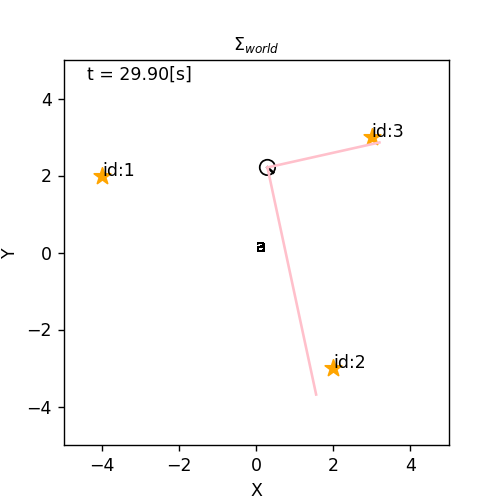

In [5]:
world = World(30, 0.1)  

### 地図を生成して3つランドマークを追加 ###
m = Map()                                  
m.append_landmark(Landmark(-4,2))
m.append_landmark(Landmark(2,-3))
m.append_landmark(Landmark(3,3))
world.append(m)          

### ロボットを作る ###
initial_pose = np.array([2, 2, math.pi/6]).T
circling = MclAgent(0.2, 10.0/180*math.pi, initial_pose, 100)  
#circling = Agent(0.2, 10.0/180*math.pi)  
r = Robot(initial_pose, sensor=Camera(m), agent=circling) 
world.append(r)

### アニメーション実行 ###
world.draw()